# Integrating scCAT-seq cell lines

## Imports

In [ ]:
# Biology
import scanpy as sc
import muon as mu
import mowgli

In [2]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Load data

Load the Liu cell lines dataset, which contains 3 well separated cell lines profiled with scRNA-seq and scATAC-seq.

In [ ]:
mdata = mu.read_h5mu('liu_preprocessed.h5mu.gz')

For computational reasons, in this simple demonstration we reduce the number of features a lot.

In [4]:
sc.pp.highly_variable_genes(mdata['rna'], n_top_genes=500)
sc.pp.highly_variable_genes(mdata['atac'], n_top_genes=500)

## Visualize independant modalities

Let us visualize the cell lines independantly using UMAP projections.

In [5]:
# Umap RNA
sc.pp.scale(mdata['rna'], zero_center=False)
sc.tl.pca(mdata['rna'], svd_solver='arpack')
sc.pp.neighbors(mdata['rna'], n_neighbors=10, n_pcs=10)
sc.tl.umap(mdata['rna'], spread=1.5, min_dist=.5)

In [6]:
# Umap ATAC
sc.pp.scale(mdata['atac'], zero_center=False)
sc.tl.pca(mdata['atac'], svd_solver='arpack')
sc.pp.neighbors(mdata['atac'], n_neighbors=10, n_pcs=10)
sc.tl.umap(mdata['atac'], spread=1.5, min_dist=.5)

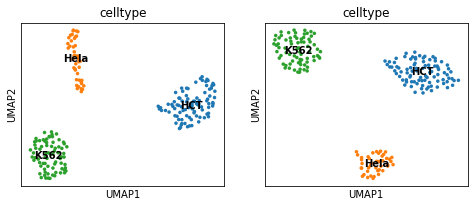

In [7]:
# Display UMAP
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
sc.pl.umap(mdata['rna'], color="celltype", legend_loc="on data", size=50, show=False, ax=axes[0])
sc.pl.umap(mdata['atac'], color="celltype", legend_loc="on data", size=50, show=False, ax=axes[1])
plt.show()

## Train model

Let us define the model and perform the dimensionaly reduction.

In [8]:
# Define the model
model = mowgli.models.MowgliModel(latent_dim=5)

In [9]:
# Perform the training.
model.train(mdata)

  4%|▍         | 8/200 [00:08<03:32,  1.11s/it, loss=-0.11106829, mass_transported=0.757, loss_inner=-0.053246647, inner_steps=60, gpu_memory_allocated=0]  


## Visualize the embedding

Now, let us display the obtained embedding.

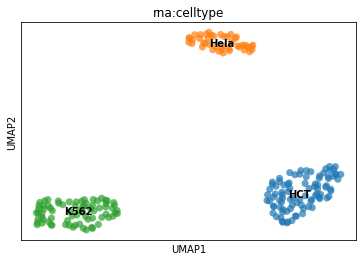

In [10]:
# First using a UMAP plot. This is pure Scanpy!
sc.pp.neighbors(mdata, use_rep="W_OT", key_added="mowgli")
sc.tl.umap(mdata, min_dist=0.5, spread=1.5, neighbors_key="mowgli")
sc.pl.umap(mdata, color="rna:celltype", size=200, alpha=.7, legend_loc='on data')

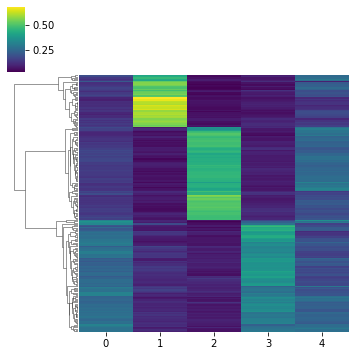

In [11]:
# Then using a dendogram.
mowgli.pl.clustermap(
    mdata,
    obsm="W_OT",
    yticklabels=False,
    figsize=(5, 5),
    col_cluster=False,
)


/users/csb/huizing/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


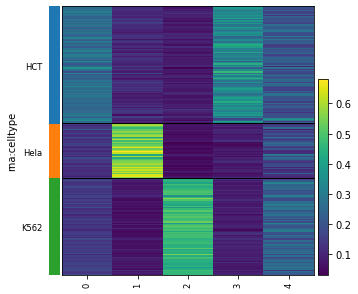

In [12]:
# Then, using a heatmap.
mowgli.pl.heatmap(
    mdata,
    obsm="W_OT",
    groupby="rna:celltype",
    figsize=(5, 5),
)


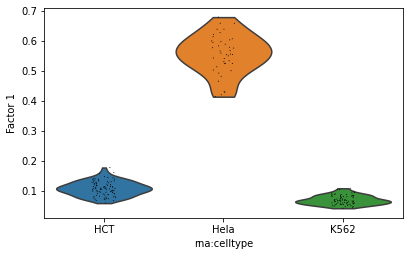

In [13]:
# Finally, display a violin plot of the value at a given dimension of the cells.
mowgli.pl.factor_violin(mdata, groupby='rna:celltype', dim=1)

## Clustering

We can perform clustering on the lower-dimensional space.

In [14]:
# Again, pure Scanpy for clustering.
sc.tl.leiden(mdata, resolution=.1, neighbors_key="mowgli")

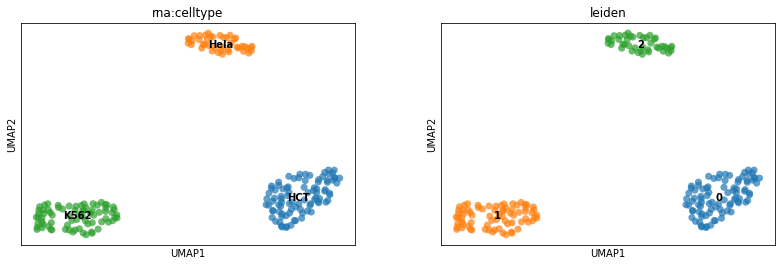

In [15]:
# Let's display the clustering results on the previously computed UMAP.
sc.pl.umap(mdata, color=['rna:celltype', 'leiden'], size=200, alpha=.7, legend_loc='on data')